import thư viện

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch.nn as nn
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn.functional as F
from torchvision import transforms
from torch import optim
import matplotlib.pyplot as plt

Tạo Dataloader

In [2]:
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, image_set='train', transform=None):
        self.root_dir = root_dir
        self.image_set = image_set
        self.transform = transform
        
        with open(os.path.join(root_dir, 'ImageSets', 'Segmentation', f'{image_set}.txt')) as f:
            self.image_ids = f.read().splitlines()
        
    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        # Đọc ảnh
        image_path = os.path.join(self.root_dir, 'JPEGImages', f'{image_id}.jpg')
        image = Image.open(image_path).convert('RGB')

        # Đọc nhãn phân vùng
        mask_path = os.path.join(self.root_dir, 'SegmentationClass', f'{image_id}.png')
        mask = Image.open(mask_path)
        
        # Chuyển đổi ảnh và mask nếu cần
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


Định nghĩa MODEL

FCN

In [3]:
class FCN(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN, self).__init__()
        self.backbone =fcn_resnet50(pretrained=True)
        self.backbone.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        return self.backbone(x)['out']


DEEPLAB

In [4]:
class DeepLabv3(nn.Module):
    def __init__(self, num_classes=21):
        super(DeepLabv3, self).__init__()
        self.backbone = deeplabv3_resnet50(pretrained=True)
        self.backbone.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        return self.backbone(x)['out']


UNET

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=21):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(),
])

train_dataset = PascalVOCDataset(root_dir='VOC2012_train_val', image_set='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = PascalVOCDataset(root_dir='VOC2012_train_val', image_set='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Xây dưng hàm Train, Evaluate, Test

In [7]:
def train(model, train_loader, val_loader, num_epochs=10, lr=0.0001, device='cuda'):
    model.to(device)
    model.train()

    # Định nghĩa loss function và optimizer
    criterion = nn.CrossEntropyLoss()  # Loss cho phân vùng ngữ nghĩa
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1)

            labels = labels.long()

            # Reset gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Tính loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Cộng dồn loss
            running_loss += loss.item()

            # Tính số lượng pixel đúng trong phân vùng
            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()

        # Tính accuracy trên toàn bộ batch trong một epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_pixels / total_pixels

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%")


In [8]:
import numpy as np
import torch

def compute_iou(preds, labels, num_classes=21):
    ious = []

    # Nếu labels có shape là (B, 1, H, W), chuyển về (B, H, W)
    if labels.ndim == 4 and labels.shape[1] == 1:
        labels = labels.squeeze(1)

    if preds.ndim == 4:
        preds = preds.argmax(dim=1)

    for c in range(num_classes):
        intersection = ((preds == c) & (labels == c)).sum()
        union = ((preds == c) | (labels == c)).sum()

        if union.item() == 0:
            iou = float('nan')
        else:
            iou = (intersection / union).item() 
        ious.append(iou)

    return ious


In [9]:
def evaluate(model, val_loader, device='cuda', num_classes=21):
    
    model.eval()  
    all_ious = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Dự đoán phân vùng
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            # Tính IoU cho batch này
            ious = compute_iou(preds, labels, num_classes)
            all_ious.append(ious)
    # Tính mIoU (mean IoU) trên toàn bộ bộ dữ liệu kiểm tra
    all_ious = np.array(all_ious)
    mean_ious = np.nanmean(all_ious, axis=0)  # Tính mIoU cho từng lớp
    mean_iou = np.nanmean(mean_ious)  # Tính mIoU trung bình trên tất cả các lớp

    print(f"Mean IoU (mIoU): {mean_iou * 100:.2f}%")

    return mean_iou


In [10]:
def test(model, image_dir, device='cuda', num_images=5, image_size=(512, 512)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

    model.eval()
    model.to(device)

    image_filenames = sorted(os.listdir(image_dir))[:num_images]

    plt.figure(figsize=(12, 5))

    for idx, filename in enumerate(image_filenames):
        # Load ảnh và transform
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Dự đoán phân vùng
        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).squeeze().cpu()

        # Hiển thị ảnh gốc
        plt.subplot(2, num_images, idx + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original")

        # Hiển thị ảnh phân vùng
        plt.subplot(2, num_images, idx + 1 + num_images)
        plt.imshow(pred, cmap='jet')
        plt.axis('off')
        plt.title("Prediction")

    plt.tight_layout()
    plt.show()


In [20]:
import torch
torch.cuda.empty_cache()


Training

        FCN

In [12]:
FCN=FCN(num_classes=21)

c:\Users\LOQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LOQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
train(FCN, train_loader, val_loader, num_epochs=10, lr=0.0001, device='cuda')

Epoch 1/10, Loss: 0.7267, Accuracy: 91.09%
Epoch 2/10, Loss: 0.1879, Accuracy: 94.73%
Epoch 3/10, Loss: 0.1558, Accuracy: 94.79%
Epoch 4/10, Loss: 0.1427, Accuracy: 94.85%
Epoch 5/10, Loss: 0.1282, Accuracy: 95.01%
Epoch 6/10, Loss: 0.1193, Accuracy: 95.17%
Epoch 7/10, Loss: 0.1054, Accuracy: 95.62%
Epoch 8/10, Loss: 0.1020, Accuracy: 95.72%
Epoch 9/10, Loss: 0.1019, Accuracy: 95.72%
Epoch 10/10, Loss: 0.0821, Accuracy: 96.46%


In [14]:
torch.save(FCN.state_dict(), 'fcn_model.pth')

In [15]:
evaluate(FCN, val_loader, device='cuda', num_classes=21)

Mean IoU (mIoU): 46.77%


C:\Users\LOQ\AppData\Local\Temp\ipykernel_9636\2535304557.py:19: RuntimeWarning: Mean of empty slice
  mean_ious = np.nanmean(all_ious, axis=0)  # Tính mIoU cho từng lớp


0.46773589832692847

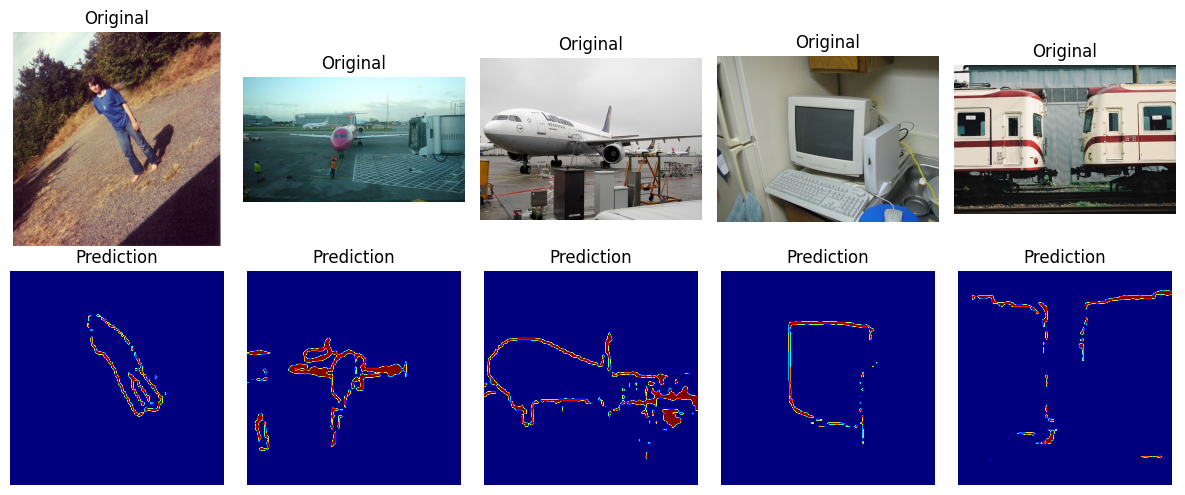

In [16]:
test(FCN, 'VOC2012_train_val/JPEGImages', device='cuda')

DEEPLABv3

In [ ]:
DEEPLABv3=DeepLabv3(num_classes=21)
train(DEEPLABv3, train_loader, val_loader, num_epochs=10, lr=0.0001, device='cuda')

In [ ]:
torch.save(DEEPLABv3.state_dict(), 'deeplabv3_model.pth')

In [ ]:
evaluate(DEEPLABv3, val_loader, device='cuda', num_classes=21)

In [ ]:
test(DEEPLABv3, 'VOC2012_train_val/JPEGImages', device='cuda')

UNET

In [ ]:
UNET=UNet(in_channels=3, out_channels=21)
train(UNET, train_loader, val_loader, num_epochs=10, lr=0.0001, device='cuda')

In [18]:
torch.save(UNET.state_dict(), 'unet_model.pth')

NameError: name 'UNET' is not defined

In [ ]:
evaluate(UNET, val_loader, device='cuda', num_classes=21)

In [ ]:
test(UNET, 'VOC2012_train_val/JPEGImages', device='cuda')